In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [49]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 11))

In [50]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 271])

In [51]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [52]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [53]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [54]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [55]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

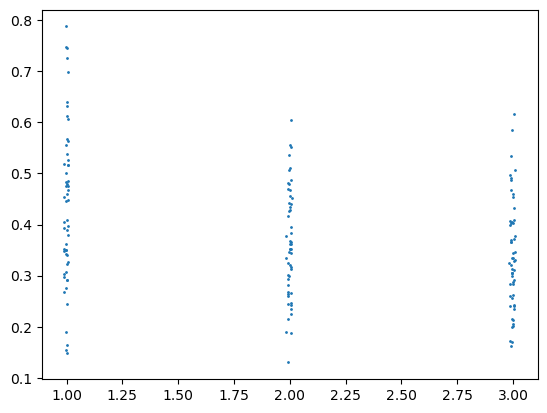

In [56]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [57]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [58]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(163, 3)


In [59]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [60]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [61]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.63it/s]


Loss: 804.4325149664655
Average Loss: 0.11007560412786885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.38it/s]


Loss: 429.02613965654746
Average Loss: 0.058706368316440535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.54it/s]


Loss: 425.7945313814562
Average Loss: 0.05826416685570008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.01it/s]


Loss: 424.5710908975452
Average Loss: 0.0580967557331069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.02it/s]


Loss: 424.2529011138249
Average Loss: 0.05805321580648945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.71it/s]


Loss: 423.29843714484014
Average Loss: 0.05792261044674879
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.13it/s]


Loss: 422.7212051884271
Average Loss: 0.057843624136347443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.43it/s]


Loss: 422.76868680957705
Average Loss: 0.05785012134778011
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.60it/s]


Loss: 422.4492427217774
Average Loss: 0.05780640978677852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.27it/s]


Loss: 422.2339258408174
Average Loss: 0.05777694661204398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▉                                                                                                                                                           | 133/7308 [00:02<00:48, 147.39it/s]

X_batch: 
torch.Size([128, 163])
tensor([[0.4350, 0.3079, 0.1016,  ..., 0.4678, 0.1833, 0.4666],
        [0.3952, 0.2675, 0.2316,  ..., 0.5250, 0.4045, 0.3743],
        [0.4419, 0.1513, 0.1596,  ..., 0.4677, 0.1293, 0.2762],
        ...,
        [0.2280, 0.1137, 0.0919,  ..., 0.2247, 0.0743, 0.0854],
        [0.4278, 0.2026, 0.0822,  ..., 0.3770, 0.1689, 0.1823],
        [0.5260, 0.4102, 0.1918,  ..., 0.6452, 0.1466, 0.3553]])
X_pred: 
torch.Size([128, 163])
tensor([[0.4502, 0.2898, 0.2169,  ..., 0.4406, 0.2243, 0.2959],
        [0.4384, 0.2879, 0.2305,  ..., 0.4344, 0.2301, 0.3004],
        [0.4491, 0.2195, 0.1165,  ..., 0.4454, 0.1182, 0.2198],
        ...,
        [0.2230, 0.1107, 0.0842,  ..., 0.2199, 0.0853, 0.1143],
        [0.3988, 0.2094, 0.1354,  ..., 0.3933, 0.1386, 0.2127],
        [0.5462, 0.3304, 0.2125,  ..., 0.5400, 0.2164, 0.3338]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.24it/s]


Loss: 421.2222072025761
Average Loss: 0.057638506732700615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.08it/s]


Loss: 420.6487435193267
Average Loss: 0.057560036059021165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.51it/s]


Loss: 421.35559087689035
Average Loss: 0.057656758467007435
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.64it/s]


Loss: 420.3960433071479
Average Loss: 0.0575254574859261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.51it/s]


Loss: 420.43882516305894
Average Loss: 0.05753131159866707
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.28it/s]


Loss: 419.6773243590724
Average Loss: 0.05742711061289989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.42it/s]


Loss: 420.1548057491891
Average Loss: 0.05749244742052396
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.52it/s]


Loss: 419.84559718798846
Average Loss: 0.05745013645155835
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.53it/s]


Loss: 419.60140603780746
Average Loss: 0.057416722227395654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.44it/s]


Loss: 419.1448679231107
Average Loss: 0.05735425122100585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.82it/s]


Loss: 418.82513612275943
Average Loss: 0.05731050029047064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.50it/s]


Loss: 419.56758317234926
Average Loss: 0.05741209403015179
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.56it/s]


Loss: 418.9933998666238
Average Loss: 0.05733352488596385
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.08it/s]


Loss: 418.7024341742508
Average Loss: 0.057293710204467815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.16it/s]


Loss: 418.7358121559955
Average Loss: 0.05729827752545095
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.21it/s]


Loss: 418.4985943476204
Average Loss: 0.057265817507884564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.79it/s]


Loss: 418.15073972940445
Average Loss: 0.05721821835377729
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.27it/s]


Loss: 418.39354602014646
Average Loss: 0.057251443078837776
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.00it/s]


Loss: 418.24645649734885
Average Loss: 0.05723131588633673
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.29it/s]


Loss: 418.38703836640343
Average Loss: 0.0572505525952933
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.19it/s]


Loss: 418.0703910898883
Average Loss: 0.05720722373972199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.77it/s]


Loss: 418.0391148601193
Average Loss: 0.05720294401479465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.54it/s]


Loss: 417.7139914515428
Average Loss: 0.05715845531630307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.52it/s]


Loss: 418.2977810406592
Average Loss: 0.057238338949187076
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.58it/s]


Loss: 417.7965460761916
Average Loss: 0.05716975178929825
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.03it/s]


Loss: 417.7802320283372
Average Loss: 0.05716751943463837
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.66it/s]


Loss: 417.5123727978207
Average Loss: 0.05713086655689938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.88it/s]


Loss: 418.0058881568257
Average Loss: 0.057198397394201655
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.36it/s]


Loss: 417.659932712093
Average Loss: 0.057151058116049945
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.25it/s]


Loss: 417.64078945782967
Average Loss: 0.057148438623129405
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.20it/s]


Loss: 417.3052467862144
Average Loss: 0.0571025241907792
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.38it/s]


Loss: 417.3126521774102
Average Loss: 0.05710353751743435
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.01it/s]


Loss: 417.45064065326005
Average Loss: 0.05712241935594691
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.92it/s]


Loss: 417.2766955071129
Average Loss: 0.05709861733813805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.86it/s]


Loss: 417.4009820681531
Average Loss: 0.05711562425672593
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.35it/s]


Loss: 417.2690111529082
Average Loss: 0.057097565839204736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.14it/s]


Loss: 417.25255219778046
Average Loss: 0.05709531365596339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.58it/s]


Loss: 417.46392519702204
Average Loss: 0.057124237164343464
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.81it/s]


Loss: 417.0651076065842
Average Loss: 0.057069664423451585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.29it/s]


Loss: 417.0897044122685
Average Loss: 0.05707303016040893
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.80it/s]


Loss: 417.0448777980637
Average Loss: 0.057066896250419226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.52it/s]


Loss: 417.112624540925
Average Loss: 0.057076166467012183
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.68it/s]


Loss: 416.4182954640128
Average Loss: 0.05698115701478007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.24it/s]


Loss: 413.67992585594766
Average Loss: 0.05660644852982316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.67it/s]


Loss: 413.95536971767433
Average Loss: 0.05664413926076551
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.84it/s]


Loss: 413.5222485100385
Average Loss: 0.05658487253831944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.18it/s]


Loss: 413.2670948202722
Average Loss: 0.056549958240321864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.61it/s]


Loss: 412.93244615383446
Average Loss: 0.05650416614037144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.36it/s]


Loss: 412.7165743680671
Average Loss: 0.05647462703449194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.69it/s]


Loss: 412.37340483046137
Average Loss: 0.056427668969685464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.36it/s]


Loss: 412.3902271282859
Average Loss: 0.05642997087141296
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.03it/s]


Loss: 411.8724226721097
Average Loss: 0.056359116402861203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.17it/s]


Loss: 411.71152650238946
Average Loss: 0.05633709995927606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.31it/s]


Loss: 411.2556510788854
Average Loss: 0.05627471963312609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.05it/s]


Loss: 410.9104869586881
Average Loss: 0.05622748863693051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.30it/s]


Loss: 410.4491422250867
Average Loss: 0.05616435991038406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.49it/s]


Loss: 410.1030161618255
Average Loss: 0.056116997285416734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.17it/s]


Loss: 410.0312339477241
Average Loss: 0.05610717486969405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.47it/s]


Loss: 409.6433580960147
Average Loss: 0.05605409935632385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.74it/s]


Loss: 409.38962373742834
Average Loss: 0.056019379274415484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.11it/s]


Loss: 409.0834329207428
Average Loss: 0.05597748124257564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.72it/s]


Loss: 408.9884717967361
Average Loss: 0.055964487109569805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.61it/s]


Loss: 408.79033488756977
Average Loss: 0.05593737477936094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.64it/s]


Loss: 408.4328989444766
Average Loss: 0.055888464551789356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.90it/s]


Loss: 408.52460797759704
Average Loss: 0.05590101368056884
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.52it/s]


Loss: 408.01424205186777
Average Loss: 0.05583117707332619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.59it/s]


Loss: 407.9688889468089
Average Loss: 0.055824971120252996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.93it/s]


Loss: 407.98736650450155
Average Loss: 0.05582749952168877
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.83it/s]


Loss: 407.9589211738203
Average Loss: 0.05582360716664207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.16it/s]


Loss: 407.70676751737483
Average Loss: 0.0557891033822352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.11it/s]


Loss: 407.7045471293386
Average Loss: 0.05578879955245465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.97it/s]


Loss: 407.61845502094366
Average Loss: 0.05577701902311763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.04it/s]


Loss: 407.70562552730553
Average Loss: 0.05578894711648954
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.92it/s]


Loss: 407.4531303537078
Average Loss: 0.055754396600124226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.48it/s]


Loss: 407.460562184453
Average Loss: 0.05575541354467064
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.04it/s]


Loss: 407.36506616091356
Average Loss: 0.05574234621796847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.12it/s]


Loss: 407.3330066911876
Average Loss: 0.05573795931734916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.20it/s]


Loss: 406.9264552060049
Average Loss: 0.055682328298577576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.85it/s]


Loss: 407.0893433406018
Average Loss: 0.05570461731535328
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.88it/s]


Loss: 407.16290739853866
Average Loss: 0.05571468355207152
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.86it/s]


Loss: 406.9368994589895
Average Loss: 0.055683757451969004
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.05it/s]


Loss: 406.98646931536496
Average Loss: 0.05569054040987479
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.94it/s]


Loss: 406.790827765828
Average Loss: 0.055663769535553916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.57it/s]


Loss: 406.85080527933314
Average Loss: 0.05567197663920815
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.86it/s]


Loss: 406.6645262944512
Average Loss: 0.05564648690400263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.24it/s]


Loss: 406.6699345873203
Average Loss: 0.05564722695502467
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.22it/s]


Loss: 406.6002840329893
Average Loss: 0.055637696227831046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.48it/s]


Loss: 406.5517147735227
Average Loss: 0.055631050187947825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.41it/s]


Loss: 406.51152024860494
Average Loss: 0.05562555011612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.56it/s]


Loss: 406.3848746048752
Average Loss: 0.05560822038928232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.33it/s]


Loss: 406.35139743518084
Average Loss: 0.05560363949578282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.82it/s]


Loss: 406.3762915281113
Average Loss: 0.05560704591243997
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.14it/s]


Loss: 406.34335545357317
Average Loss: 0.055602539060423256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.32it/s]


Loss: 406.20943713374436
Average Loss: 0.055584214167179034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.04it/s]


Loss: 406.25965835596435
Average Loss: 0.05559108625560541
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.62it/s]


Loss: 406.24022263661027
Average Loss: 0.05558842674283118
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.77it/s]


Loss: 406.2120830793865
Average Loss: 0.05558457622870642
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.17it/s]


Loss: 406.1928256135434
Average Loss: 0.05558194110749089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.91it/s]


Loss: 406.1392843136564
Average Loss: 0.05557461471177564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.49it/s]


Loss: 405.94093263777904
Average Loss: 0.055547472993675295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.54it/s]


Loss: 405.91708666831255
Average Loss: 0.055544209998400734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.61it/s]


Loss: 405.955277887173
Average Loss: 0.0555494359451523
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.13it/s]


Loss: 406.0072031659074
Average Loss: 0.05555654121044163
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.55it/s]


Loss: 405.88654184457846
Average Loss: 0.055540030356400996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.71it/s]


Loss: 406.0815289115999
Average Loss: 0.055566711673727405
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.02it/s]


Loss: 405.831919220509
Average Loss: 0.055532555996238235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.21it/s]


Loss: 405.9220281280577
Average Loss: 0.05554488616968496
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.09it/s]


Loss: 405.76259742840193
Average Loss: 0.05552307025566529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.93it/s]


Loss: 405.73123831511475
Average Loss: 0.05551877918926037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.70it/s]


Loss: 405.80358146247454
Average Loss: 0.05552867836103921
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.30it/s]


Loss: 405.5756804761477
Average Loss: 0.05549749322333712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.20it/s]


Loss: 405.640181762632
Average Loss: 0.055506319343545704
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.47it/s]


Loss: 405.5578992536757
Average Loss: 0.05549506010586695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.93it/s]


Loss: 405.50044415914454
Average Loss: 0.055487198160802484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.65it/s]


Loss: 405.4419322574977
Average Loss: 0.055479191606116265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.75it/s]


Loss: 405.65701187890954
Average Loss: 0.05550862231512172
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.43it/s]


Loss: 405.523405529093
Average Loss: 0.055490340110713327
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.07it/s]


Loss: 405.4572405938525
Average Loss: 0.05548128634289169
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.98it/s]


Loss: 405.50756497704424
Average Loss: 0.055488172547488265
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.59it/s]


Loss: 405.32988778082654
Average Loss: 0.05546385984959312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.95it/s]


Loss: 405.36226697755046
Average Loss: 0.05546829050048583
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.00it/s]


Loss: 405.48377757146955
Average Loss: 0.05548491756588253
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.16it/s]


Loss: 405.4306258757133
Average Loss: 0.055477644482172045
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.04it/s]


Loss: 405.3627698335331
Average Loss: 0.05546835930945992
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.26it/s]


Loss: 405.3704896639101
Average Loss: 0.05546941566282295
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.38it/s]


Loss: 405.3148435081821
Average Loss: 0.055461801246330336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.36it/s]


Loss: 405.3641467348207
Average Loss: 0.05546854771959779
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.51it/s]


Loss: 405.36935586761683
Average Loss: 0.05546926051828364
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.48it/s]


Loss: 405.41902551450767
Average Loss: 0.05547605713115868
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.14it/s]


Loss: 405.2527692508884
Average Loss: 0.05545330723192233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.30it/s]


Loss: 405.3149348984007
Average Loss: 0.0554618137518337
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.48it/s]


Loss: 405.2852566251531
Average Loss: 0.0554577526854342
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.60it/s]


Loss: 405.18954111030325
Average Loss: 0.05544465532434363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.40it/s]


Loss: 405.12983509129845
Average Loss: 0.055436485371004166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.23it/s]


Loss: 405.31231074174866
Average Loss: 0.055461454671832056
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.75it/s]


Loss: 405.12026089639403
Average Loss: 0.05543517527317926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.08it/s]


Loss: 405.14142332598567
Average Loss: 0.055438071062669084
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.99it/s]


Loss: 405.258358907653
Average Loss: 0.05545407210011672
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.64it/s]


Loss: 404.9873616597615
Average Loss: 0.055416989827553574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.47it/s]


Loss: 405.1401999925729
Average Loss: 0.05543790366619771
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.00it/s]


Loss: 404.9950728325639
Average Loss: 0.055418044996245745
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.81it/s]


Loss: 404.97069187043235
Average Loss: 0.055414708794530976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.17it/s]


Loss: 405.0380695099011
Average Loss: 0.05542392850436523
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.20it/s]


Loss: 405.21852751937695
Average Loss: 0.05544862171857922
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.05it/s]


Loss: 404.94955153833143
Average Loss: 0.05541181602878099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.01it/s]


Loss: 404.9594070671592
Average Loss: 0.05541316462331133
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.55it/s]


Loss: 405.06496451911516
Average Loss: 0.05542760871909075
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.14it/s]


Loss: 404.8270221906714
Average Loss: 0.05539504956084721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.10it/s]


Loss: 404.9667044763919
Average Loss: 0.05541416317410945
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.90it/s]


Loss: 404.86110038799234
Average Loss: 0.05539971269676961
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.08it/s]


Loss: 404.87864170293324
Average Loss: 0.05540211298617039
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.57it/s]


Loss: 404.81223603035323
Average Loss: 0.05539302627673142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.52it/s]


Loss: 404.82052376074716
Average Loss: 0.05539416033945637
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.42it/s]


Loss: 404.7677051189821
Average Loss: 0.055386932829636304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.76it/s]


Loss: 404.82014972763136
Average Loss: 0.05539410915813237
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.74it/s]


Loss: 404.7269203083124
Average Loss: 0.05538135198526442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.01it/s]


Loss: 404.73852185346186
Average Loss: 0.05538293949828433
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.23it/s]


Loss: 404.85873594065197
Average Loss: 0.055399389154440606
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.33it/s]


Loss: 404.74570644740015
Average Loss: 0.055383922611850045
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.88it/s]


Loss: 404.6979389276821
Average Loss: 0.055377386279102644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.54it/s]


Loss: 404.7842177010607
Average Loss: 0.05538919235099353
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.04it/s]


Loss: 404.64528415421955
Average Loss: 0.055370181192421944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.88it/s]


Loss: 404.67916569975205
Average Loss: 0.05537481741923263
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.05it/s]


Loss: 404.7057611839846
Average Loss: 0.05537845664805481
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.48it/s]


Loss: 404.66895604645833
Average Loss: 0.05537342036760513
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.03it/s]


Loss: 404.5780810737051
Average Loss: 0.05536098536859676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.47it/s]


Loss: 404.59093980514444
Average Loss: 0.05536274491039196
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.81it/s]


Loss: 404.5625597764738
Average Loss: 0.05535886149103363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.57it/s]


Loss: 404.62007475621067
Average Loss: 0.0553667316305707
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.18it/s]


Loss: 404.74155422486365
Average Loss: 0.05538335443689979
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.33it/s]


Loss: 404.587917936733
Average Loss: 0.0553623314089673
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.82it/s]


Loss: 404.5840046184603
Average Loss: 0.055361795924802996
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.77it/s]


Loss: 404.5023977323435
Average Loss: 0.05535062913688335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.23it/s]


Loss: 404.52931811031885
Average Loss: 0.055354312822977404
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.92it/s]


Loss: 404.6645256066695
Average Loss: 0.0553728141224233
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.34it/s]


Loss: 404.5734814372845
Average Loss: 0.05536035597116646
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.46it/s]


Loss: 404.6065973204095
Average Loss: 0.055364887427532775
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.58it/s]


Loss: 404.5851185834035
Average Loss: 0.05536194835569287
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.12it/s]


Loss: 404.48053724179044
Average Loss: 0.05534763782728386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.15it/s]


Loss: 404.58715264103375
Average Loss: 0.055362226688701936
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.40it/s]


Loss: 404.44815249578096
Average Loss: 0.0553432064170472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.50it/s]


Loss: 404.55652775848284
Average Loss: 0.05535803609174642
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.27it/s]


Loss: 404.49320850288495
Average Loss: 0.05534937171632252
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.01it/s]


Loss: 404.6277680902276
Average Loss: 0.055367784358268696
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.33it/s]


Loss: 404.40776648093015
Average Loss: 0.055337680142437076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.60it/s]


Loss: 404.38590778503567
Average Loss: 0.0553346890784121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.42it/s]


Loss: 404.42935909028165
Average Loss: 0.05534063479615239
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.97it/s]


Loss: 404.62717234762385
Average Loss: 0.05536770283902899
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.46it/s]


Loss: 404.45847635739483
Average Loss: 0.05534461909652365
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.18it/s]


Loss: 404.5201571723446
Average Loss: 0.05535305927371984
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.65it/s]


Loss: 404.3832989661023
Average Loss: 0.0553343320971678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.06it/s]


Loss: 404.46754892985336
Average Loss: 0.055345860554167126
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.39it/s]


Loss: 404.4810407741461
Average Loss: 0.055347706728810356
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.26it/s]


Loss: 404.4854043428786
Average Loss: 0.05534830382360134
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.71it/s]


Loss: 404.3717167477589
Average Loss: 0.055332747228757376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.74it/s]


Loss: 404.3653771420941
Average Loss: 0.05533187974029749
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.72it/s]


Loss: 404.38495237287134
Average Loss: 0.05533455834330478
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.59it/s]


Loss: 404.3628081122879
Average Loss: 0.05533152820365187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.63it/s]


Loss: 404.3828929250594
Average Loss: 0.05533427653599609
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.80it/s]


Loss: 404.37426083465107
Average Loss: 0.055333095352305836
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.34it/s]


Loss: 404.43274760758504
Average Loss: 0.05534109846847086
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.46it/s]


Loss: 404.3712008870207
Average Loss: 0.05533267664026008
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 214.97it/s]


Loss: 404.2826296130661
Average Loss: 0.05532055687097237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.77it/s]


Loss: 404.30185026233084
Average Loss: 0.055323186954341935
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.00it/s]


Loss: 404.365061304532
Average Loss: 0.05533183652224028
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.87it/s]


Loss: 404.38720888341777
Average Loss: 0.05533486711595755
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.12it/s]


Loss: 404.3524227598682
Average Loss: 0.05533010710999839
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.56it/s]


Loss: 404.2068782162387
Average Loss: 0.05531019132679785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.94it/s]


Loss: 404.2508429870941
Average Loss: 0.055316207305294754
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.32it/s]


Loss: 404.22143059945665
Average Loss: 0.05531218262171
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.17it/s]


Loss: 404.187116910005
Average Loss: 0.055307487261905444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.09it/s]


Loss: 404.1817435075063
Average Loss: 0.05530675198515412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.25it/s]


Loss: 404.1739224246703
Average Loss: 0.05530568177677481
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.17it/s]


Loss: 404.1745792143047
Average Loss: 0.05530577164946698
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.48it/s]


Loss: 404.2408658741042
Average Loss: 0.055314842073632214
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.35it/s]


Loss: 404.28744476637803
Average Loss: 0.05532121575894609
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.62it/s]


Loss: 404.3949247475248
Average Loss: 0.055335922926590696
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.14it/s]


Loss: 404.41322300885804
Average Loss: 0.05533842679376821
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.06it/s]


Loss: 404.3654437707737
Average Loss: 0.0553318888575224
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.29it/s]


Loss: 404.2015171973035
Average Loss: 0.05530945774456807
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.85it/s]


Loss: 404.2073970276397
Average Loss: 0.05531026231905305
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.49it/s]


Loss: 404.2211778059136
Average Loss: 0.05531214803036585
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.11it/s]


Loss: 404.1670013454277
Average Loss: 0.05530473472159657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.05it/s]


Loss: 404.2663996468764
Average Loss: 0.055318336021740064
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.94it/s]


Loss: 404.1929480326362
Average Loss: 0.05530828517140616
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.27it/s]


Loss: 404.2044725159649
Average Loss: 0.05530986213956827
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.08it/s]


Loss: 404.1766774826683
Average Loss: 0.055306058768838026
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.80it/s]


Loss: 404.13358701742254
Average Loss: 0.05530016242712405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.33it/s]


Loss: 404.0697655521799
Average Loss: 0.05529142933116857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.67it/s]


Loss: 404.14537008618936
Average Loss: 0.05530177477917205
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.09it/s]


Loss: 404.31580837024376
Average Loss: 0.05532509693079417
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.11it/s]


Loss: 404.3741633114405
Average Loss: 0.05533308200758628
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.30it/s]


Loss: 404.2126294267364
Average Loss: 0.05531097830141439
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.10it/s]


Loss: 404.15644888952374
Average Loss: 0.055303290762113266
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.47it/s]


Loss: 404.0861317785457
Average Loss: 0.055293668825745164
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.92it/s]


Loss: 404.25468858960085
Average Loss: 0.05531673352348123
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.32it/s]


Loss: 404.25361007871106
Average Loss: 0.0553165859439944
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.50it/s]


Loss: 404.1556719467044
Average Loss: 0.05530318444809858
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.98it/s]

Loss: 404.09096678253263
Average Loss: 0.055294330430012674
Done, best loss: 404.0697655521799
Done


<All keys matched successfully>

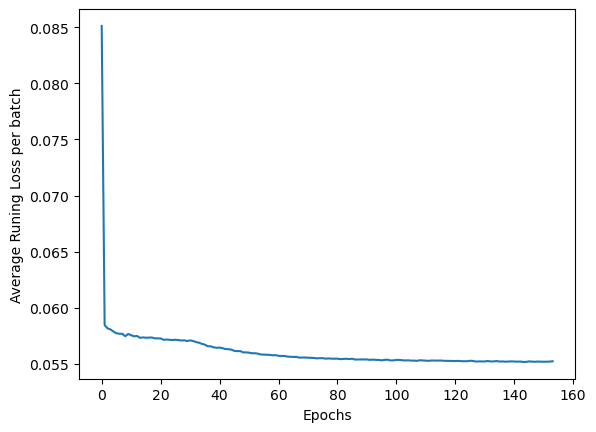

In [47]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [48]:
torch.save(final_model, 'model_100206_15g_05.pt')